## 1. Imports and Data Loading

This section loads the required Python packages and reads the Alt-Baltimore
GeoJSON layers (points, lines, polygons) into Shapely-based data structures.
These will be used for all spatial analysis steps that follow.


In [4]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import shape
from shapely.ops import transform
import pyproj

# --- Helper to load a GeoJSON file into a DataFrame of Shapely geometries ---
def load_geojson(path):
    with open(path, "r") as f:
        data = json.load(f)
    names = []
    geoms = []
    for feat in data["features"]:
        names.append(feat.get("properties", {}).get("name"))
        geoms.append(shape(feat["geometry"]))
    return pd.DataFrame({"name": names, "geometry": geoms})

# --- Load layers ---
points_df   = load_geojson("../data/points/alt_baltimore_points.geojson")
lines_df    = load_geojson("../data/lines/alt_baltimore_lines.geojson")
polygons_df = load_geojson("../data/polygons/alt_baltimore_polygons.geojson")

print("Points:", len(points_df))
print("Lines:", len(lines_df))
print("Polygons:", len(polygons_df))

points_df.head(), lines_df.head(), polygons_df.head()


Points: 992
Lines: 34
Polygons: 428


(                                          name  \
 0  Pratt Bay Brook Museum and Fine Collections   
 1                                  Cherry Hill   
 2                               Bay Brook Park   
 3                               South Pumphrey   
 4                                     Pumphrey   
 
                                        geometry  
 0  POINT (-76.60233278825561 39.22970148880668)  
 1   POINT (-76.6224979217954 39.25066813572256)  
 2  POINT (-76.64681336590976 39.22642894892758)  
 3  POINT (-76.65140428233612 39.20359515443015)  
 4  POINT (-76.63798966907282 39.21860355772918)  ,
                name                                           geometry
 0           Route 3  LINESTRING (-76.45554285063292 39.245791306650...
 1     Untitled path  LINESTRING (-76.53950836920237 39.209825284940...
 2     Untitled path  LINESTRING (-76.82611113657529 39.113365469715...
 3      Potee Street  LINESTRING (-76.61416726480216 39.206604894648...
 4  Pennnington Ave   LIN

## 2. Basic Metadata Overview

Here we inspect the structure of each layer to confirm successful loading.
We print the number of features in the points, lines, and polygons datasets, 
and preview the first few records in each.


In [7]:
polygons_df["centroid"] = polygons_df["geometry"].apply(lambda g: g.centroid)
polygons_df[["name", "centroid"]].head()


,name,centroid
0,Pratt Tech,POINT (-76.59699528842043 39.2283109328175)
1,Aurum Hill,POINT (-76.61155786977392 39.22774376092393)
2,Jones Family Community Tower,POINT (-76.61841882813114 39.311482245908195)
3,UB Golf Course,POINT (-76.6504331319484 39.275821143591045)
4,Baltimore Central Station,POINT (-76.61551957671793 39.30765201231822)


## 3. Bounding Box Computation

This section computes bounding boxes for each polygon. Bounding boxes help
summarize each district's spatial extent and provide quick visual cues for
map framing and spatial comparisons.


In [8]:
# WGS84 (lat/lon) → US National Atlas Equal Area
proj_aea = pyproj.Transformer.from_crs("EPSG:4326", "EPSG:2163", always_xy=True)

def area_sqkm(geom):
    geom_aea = transform(proj_aea.transform, geom)  # reproject
    return geom_aea.area / 1_000_000  # sq meters → sq km

polygons_df["area_sqkm"] = polygons_df["geometry"].apply(area_sqkm)
polygons_df.sort_values("area_sqkm", ascending=False).head()


,name,geometry,centroid,area_sqkm
417,New York,POLYGON ((-79.04750141092168 43.28251719093576...,POINT (-75.532393386428 42.91128841977928),124666.318617
389,York,POLYGON ((-79.12851642618728 43.77538838662103...,POINT (-80.9046100652057 43.47418722412008),49283.958055
95,Untitled polygon,POLYGON ((-76.58026453142608 39.31501067223398...,POINT (-76.5442272972754 39.34606433080446),61.743350
423,Untitled polygon,POLYGON ((-76.66488940579157 39.39532747943856...,POINT (-76.61812490397445 39.373151638323684),60.811255
129,Untitled polygon,POLYGON ((-76.67190339304354 39.33648974840074...,POINT (-76.68653639011607 39.36721534224423),36.301235


## 4. Centroid Calculation

We compute the centroid for each polygon. Centroids are used for labeling,
spatial joins, and measuring proximity to key anchor institutions.


In [9]:
# --- Compute centroids for polygons, lines, and points ---
polygons_df["centroid"] = polygons_df["geometry"].apply(lambda g: g.centroid)
lines_df["centroid"] = lines_df["geometry"].apply(lambda g: g.centroid)
points_df["centroid"] = points_df["geometry"]  # points are their own centroids

# Show a preview
polygons_df[["name", "centroid"]].head()


,name,centroid
0,Pratt Tech,POINT (-76.59699528842043 39.2283109328175)
1,Aurum Hill,POINT (-76.61155786977392 39.22774376092393)
2,Jones Family Community Tower,POINT (-76.61841882813114 39.311482245908195)
3,UB Golf Course,POINT (-76.6504331319484 39.275821143591045)
4,Baltimore Central Station,POINT (-76.61551957671793 39.30765201231822)


## 5. Area Computation (sq km and sq miles)

To compute accurate areas, we reproject each district's geometry into an
equal-area coordinate reference system (EPSG:2163 – US National Atlas Equal Area).
This ensures that area measurements are meaningful and comparable.


In [10]:
from shapely.ops import transform
import pyproj

# Lat/lon (WGS84) → Equal Area projection transformer
proj_aea = pyproj.Transformer.from_crs("EPSG:4326", "EPSG:2163", always_xy=True)

# Function to compute area in sq km
def compute_area_sq_km(geom):
    geom_aea = transform(proj_aea.transform, geom)
    return geom_aea.area / 1_000_000  # sq meters → sq km

# Compute area
polygons_df["area_sqkm"] = polygons_df["geometry"].apply(compute_area_sq_km)
polygons_df["area_sqmi"] = polygons_df["area_sqkm"] * 0.386102  # km² → mi²

# View largest districts
polygons_df[["name", "area_sqkm", "area_sqmi"]].sort_values("area_sqkm", ascending=False).head()


,name,area_sqkm,area_sqmi
417,New York,124666.318617,48133.914951
389,York,49283.958055,19028.634773
95,Untitled polygon,61.743350,23.839231
423,Untitled polygon,60.811255,23.479347
129,Untitled polygon,36.301235,14.015979


## 6. Nearest Anchor Institution

For each district (polygon), we compute the nearest anchor institution
from the points layer. This helps evaluate anchor–district relationships
and provides insight into imagined walkability and conceptual connectivity
within the Alt-Baltimore worldbuild.


In [11]:
from shapely.ops import nearest_points

# Helper: find nearest point feature to a given geometry
def nearest_point_name(row, points_df):
    # Compute distances between this polygon and all point anchors
    distances = points_df["geometry"].apply(lambda p: row.geometry.distance(p))
    nearest_idx = distances.idxmin()
    return points_df.loc[nearest_idx, "name"]

# Compute nearest anchor for each polygon
polygons_df["nearest_anchor"] = polygons_df.apply(lambda r: nearest_point_name(r, points_df), axis=1)

# Preview
polygons_df[["name", "nearest_anchor"]].head()


,name,nearest_anchor
0,Pratt Tech,Pratt Tech Athletics Campus
1,Aurum Hill,Pratt Bay Brook Museum and Fine Collections
2,Jones Family Community Tower,Jones Family Community Tower (370)
3,UB Golf Course,UB Golf Course and Country Club
4,Baltimore Central Station,Baltimore Central Station


## 7. Visualizing Districts, Centroids, and Nearest Anchors

This visualization overlays:
- District polygons
- Their centroids
- Point anchors
- Labels showing each district's nearest anchor

This provides a high-level spatial representation of the imagined city form.


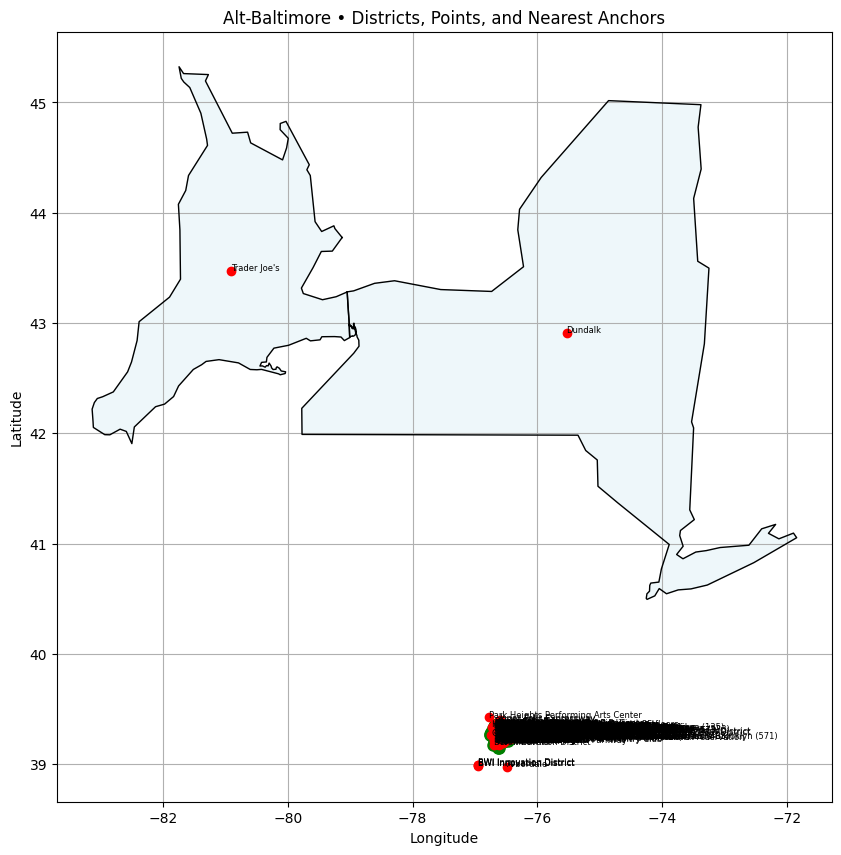

In [12]:
fig, ax = plt.subplots(figsize=(10, 10))

# Plot polygons
for geom in polygons_df["geometry"]:
    xs, ys = geom.exterior.xy
    ax.plot(xs, ys, color="black", linewidth=1)
    ax.fill(xs, ys, alpha=0.2, color="lightblue")

# Plot points
for geom in points_df["geometry"]:
    ax.plot(geom.x, geom.y, "o", color="green", markersize=8)

# Plot centroids with nearest labels
for idx, row in polygons_df.iterrows():
    c = row.centroid
    ax.plot(c.x, c.y, "o", color="red", markersize=6)
    ax.text(c.x, c.y, row["nearest_anchor"], fontsize=6)

plt.title("Alt-Baltimore • Districts, Points, and Nearest Anchors")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()


In [13]:
# Look at polygons whose centroids are way north of Baltimore (lat > 41)
out_of_region = polygons_df[polygons_df["centroid"].apply(lambda c: c.y > 41)]
out_of_region[["name", "centroid"]]


,name,centroid
389,York,POINT (-80.9046100652057 43.47418722412008)
417,New York,POINT (-75.532393386428 42.91128841977928)


In [14]:
# Define a rough bounding box around metro Baltimore
def in_baltimore_bbox(geom):
    c = geom.centroid
    return (39.0 <= c.y <= 40.0) and (-77.5 <= c.x <= -75.5)

polygons_bmore = polygons_df[polygons_df["geometry"].apply(in_baltimore_bbox)].copy()
points_bmore   = points_df[points_df["geometry"].apply(in_baltimore_bbox)].copy()
lines_bmore    = lines_df[lines_df["geometry"].apply(in_baltimore_bbox)].copy()

print("Baltimore-only polygons:", len(polygons_bmore))
print("Baltimore-only points:", len(points_bmore))
print("Baltimore-only lines:", len(lines_bmore))


Baltimore-only polygons: 422
Baltimore-only points: 992
Baltimore-only lines: 34


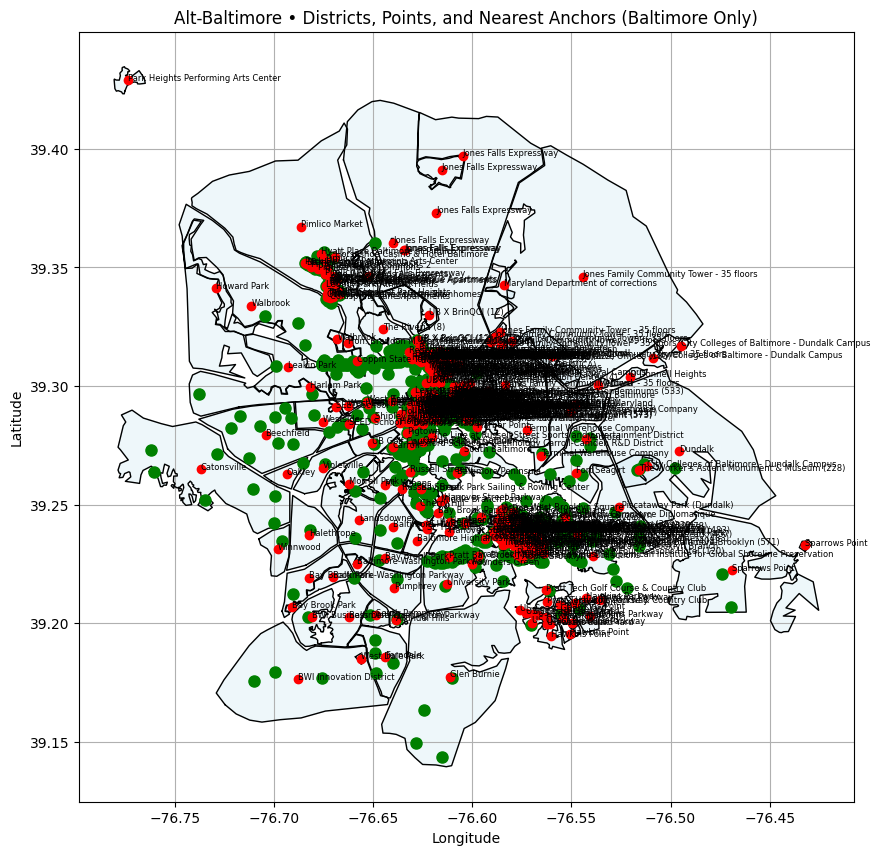

In [15]:
fig, ax = plt.subplots(figsize=(10, 10))

# Plot Baltimore-only polygons
for geom in polygons_bmore["geometry"]:
    xs, ys = geom.exterior.xy
    ax.plot(xs, ys, color="black", linewidth=1)
    ax.fill(xs, ys, alpha=0.2, color="lightblue")

# Plot Baltimore-only points
for geom in points_bmore["geometry"]:
    ax.plot(geom.x, geom.y, "o", color="green", markersize=8)

# Plot centroids + labels for nearest anchors (recompute on filtered data)
polygons_bmore["centroid"] = polygons_bmore["geometry"].apply(lambda g: g.centroid)

def nearest_point_name(row, points_df):
    distances = points_df["geometry"].apply(lambda p: row.geometry.distance(p))
    nearest_idx = distances.idxmin()
    return points_df.loc[nearest_idx, "name"]

polygons_bmore["nearest_anchor"] = polygons_bmore.apply(
    lambda r: nearest_point_name(r, points_bmore),
    axis=1
)

for idx, row in polygons_bmore.iterrows():
    c = row.centroid
    ax.plot(c.x, c.y, "o", color="red", markersize=6)
    ax.text(c.x, c.y, row["nearest_anchor"], fontsize=6)

plt.title("Alt-Baltimore • Districts, Points, and Nearest Anchors (Baltimore Only)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()


## 8. Interactive Web Map Overlay (Folium + Basemap)

Here we overlay the Alt-Baltimore worldbuild layers on top of a real web
basemap (OpenStreetMap) using Folium/Leaflet. This provides a familiar
geographic context for the speculative districts and anchors.


In [16]:
import json
import folium

# --- Load GeoJSON directly for Folium ---
with open("../data/polygons/alt_baltimore_polygons.geojson") as f:
    polys_geojson = json.load(f)

with open("../data/points/alt_baltimore_points.geojson") as f:
    points_geojson = json.load(f)

# If you made *_bmore versions, use those instead:
# with open("../data/polygons/alt_baltimore_polygons_bmore.geojson") as f:
#     polys_geojson = json.load(f)
# with open("../data/points/alt_baltimore_points_bmore.geojson") as f:
#     points_geojson = json.load(f)

# --- Center the map roughly on Baltimore ---
m = folium.Map(location=[39.29, -76.61], zoom_start=11, tiles="CartoDB positron")

# --- Add polygons layer ---
folium.GeoJson(
    polys_geojson,
    name="Alt-Baltimore Districts",
    style_function=lambda feature: {
        "color": "black",
        "weight": 1,
        "fillOpacity": 0.3,
    },
    tooltip=folium.GeoJsonTooltip(fields=["name"], aliases=["District:"])
).add_to(m)

# --- Add points layer ---
folium.GeoJson(
    points_geojson,
    name="Anchor Institutions",
    marker=None,
    tooltip=folium.GeoJsonTooltip(fields=["name"], aliases=["Anchor:"])
).add_to(m)

# Layer control toggle
folium.LayerControl().add_to(m)

m


In [17]:
m.save("../webapp/alt_baltimore_map.html")
